In [1]:
from pyspark import SparkContext, SparkConf
import json

sc = SparkContext.getOrCreate(SparkConf().setMaster('local[*]'))

24/09/06 15:44:14 WARN Utils: Your hostname, DESKTOP-2J74AJH resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
24/09/06 15:44:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/06 15:44:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/09/06 15:44:16 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/09/06 15:44:16 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
24/09/06 15:44:16 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
24/09/06 15:44:16 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.
24/09/06 15:44:16 WARN Utils: Service 'SparkUI' could not bind on port 4044. Attempting port

In [2]:
fields = ['product_id', 'user_id', 'score', 'time']

def validate(line):
    for x in fields:
        if x not in line:
            return False
    return True

rdd = sc.textFile('movies.json')
review = rdd.map(lambda x: json.loads(x)).filter(validate)

In [3]:
# no. of movies
r1 = review.groupBy(lambda x: x['product_id']).count()
print(r1)
# no. of users
r2 = review.groupBy(lambda x: x['user_id']).count()
print(r2)
# no. of reviews
print(review.count())

1539


36409
50000


In [4]:
# no. of people watching each product
r1 = review.map(lambda x: (x['product_id'], 1)).reduceByKey(lambda x, y: x + y).sortBy(lambda x: x[1], ascending = False)
r1.take(5)

[('B002VL2PTU', 669),
 ('B001NFNFMQ', 648),
 ('B003DBEX6K', 626),
 ('B000KKQNRO', 608),
 ('B000ZLFALI', 591)]

In [5]:
# no. of movies watched by each user
r2 = review.map(lambda x: (x['user_id'], 1)).reduceByKey(lambda x, y: x + y).sortBy(lambda x: x[1], ascending= False)
r2.take(5)

[('A3LZGLA88K0LA0', 56),
 ('ANCOMAI0I7LVG', 54),
 ('A2NJO6YE954DBH', 54),
 ('A328S9RN3U5M68', 53),
 ('A16CZRQL23NOIW', 51)]

In [6]:
# has a particular person written a review
george = review.filter(lambda x: 'George' in x['profile_name'])
print(f'George has written {george.count()} no. of reviews')

George has written 102 no. of reviews


In [7]:
george.take(5)

[{'user_id': 'A18LC2UPXD4DZ9',
  'product_id': 'B000NDFLWG',
  'review': 'Very enlighteniing on the development of the debt problems we all face especially how we have gotten there with many ideas as to how to decrease our debts and change our purchasing patterns.All families and individuals should view this, an eye opener.',
  'summary': 'In Debt We Trust',
  'profile_name': 'George Satterthwaite',
  'helpfulness': '1/1',
  'time': 1201392000,
  'score': 4.0},
 {'user_id': 'A3NN4RTUN0LHBN',
  'product_id': 'B0001G6PZC',
  'review': "Way better than Lord of the Rings. The battle sequences were suberb and stunning. I loved the fighting and plot. Tom Cruise was awesome in acting in this movie. It was also historicly accurate. So you can learn from this film. It was very educational. It deserves some academy awards. If you like movies like Gladiator you'd pamper yourself by coming to this movie",
  'summary': 'My Favortite movie by far',
  'profile_name': 'George Rownd',
  'helpfulness': 

In [8]:
# best rated movie
r1 = review.map(lambda x: (x['product_id'], x['score'])).reduceByKey(lambda x, y: x + y).sortBy(lambda x: x[1], ascending= False)
r1.take(5)

[('B002VL2PTU', 3169.0),
 ('B001NFNFMQ', 3100.0),
 ('B000063W82', 2843.0),
 ('B000ZLFALI', 2462.0),
 ('B000ZLFALS', 2462.0)]

In [9]:
# worst rated movie
r2 = review.map(lambda x: (x['product_id'], x['score'])).reduceByKey(lambda x, y: x + y).sortBy(lambda x: x[1], ascending= True)
r2.take(5)

[('B007NF02Q2', 1.0),
 ('B004XSUBE0', 1.0),
 ('B0099VUXCQ', 1.0),
 ('6303149073', 1.0),
 ('B000SKO8DC', 1.0)]

In [10]:
from pyspark.mllib.recommendation import ALS
import hashlib

def get_hash(x):
    return int(hashlib.sha1(x).hexdigest(), 16) % (10 ** 8)

rating = review.map(lambda x: (get_hash(x['user_id'].encode('utf-8')), get_hash(x['product_id'].encode('utf-8')), int(x['score'])))
train = rating.filter(lambda x: ((x[0] + x[1]) % 10) >= 2)
test = rating.filter(lambda x: ((x[0] + x[1]) % 10) < 2)
# no. of training samples
print(train.count())
# no. of testing samples
print(test.count())

39992
10008


In [11]:
# building model
rank = 20
numiterations = 20
model = ALS.train(train, rank, numiterations)
format_test = test.map(lambda x: (int(x[0]), int(x[1])))
predict = model.predictAll(format_test).map(lambda x: ((int(x[0]), int(x[1])), int(x[2])))
true_and_predict = test.map(lambda x: ((int(x[0]), int(x[1])), int(x[2]))).join(predict)
mse = true_and_predict.map(lambda x: (((int(x[1][0]) - int(x[1][1])) ** 2), 1)).reduce(lambda x, y: (x[0] + y[0], x[1] + y[1]))
print(mse[0] / mse[1])

24/09/06 15:44:31 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/09/06 15:44:31 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


9.562934148374548


In [12]:
good_reviews = review.filter(lambda x: x['score'] == 5.0)
bad_reviews = review.filter(lambda x: x['score'] == 1.0)

good_words = good_reviews.flatMap(lambda x: x['review'].split())
good_words = good_words.map(lambda x: (x.strip(), 1)).reduceByKey(lambda x, y: x + y).filter(lambda x: x[1] > 20)
no_good = good_words.count()

bad_words = bad_reviews.flatMap(lambda x: x['review'].split())
bad_words = bad_words.map(lambda x: (x.strip(), 1)).reduceByKey(lambda x, y: x + y).filter(lambda x: x[1] > 20)
no_bad = bad_words.count()

In [13]:
from math import fabs
# frequencies of words
frequency_good = good_words.map(lambda x: (x[0], float(x[1]) / no_good))
frequency_bad = bad_words.map(lambda x: (x[0], float(x[1]) / no_bad))

# joined frequencies
joined = frequency_good.join(frequency_bad)

# relative difference between good and bad score
result = joined.map(lambda x: (x[0], fabs(x[1][0] - x[1][1]) / x[1][0])).sortBy(lambda x: x[1], ascending = False)
result.take(5)

[('waste', 18.822084206132658),
 ('worst', 13.979516591560836),
 ('poorly', 11.263640087892442),
 ('wasted', 9.67554281032364),
 ('garbage', 8.553397685374847)]

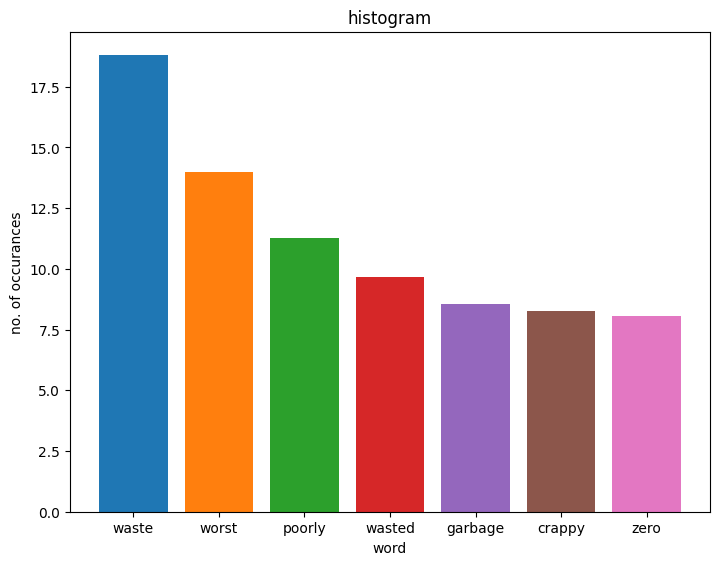

In [15]:
from matplotlib import pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
plt.title('histogram')
plt.xlabel('word')
plt.ylabel('no. of occurances')
for x in result.take(7):
    plt.bar(x[0], x[1])
    